<a href="https://colab.research.google.com/github/SEAFARI/pytorch-deeplearning/blob/main/06_Pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Transfer Learning

What is transfer Learning??

Transfer Learning involves taking the parameters of what one model has learned
on another dataset and applying it to our own problem.

Pretrained model = foundation model




In [6]:
import torch
import torchvision

In [7]:
## Checking the versions
print(torch.__version__ )
print(torchvision.__version__ )

2.8.0+cu126
0.23.0+cu126


In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 34.09 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [9]:
## setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
## check gpu
!nvidia-smi

Fri Nov 21 16:33:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Get the data

In [11]:
from torch.utils import data
import os
import zipfile

from pathlib import Path
import requests

## setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

## if image folder dosent exist then downlaod from github
if image_path.is_dir():
  print(f"{image_path} directory exists. Skipping re-download....")
else:
  print(f"Couldn't find {image_path}, Downloading it....")
  image_path.mkdir(parents=True, exist_ok=True)

  ## Download from github
  with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data.... ")
    f.write(request.content)

  ## unzip pizza_steak_sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza steak sushi data")
    zip_ref.extractall(image_path)


    ## Remove the zip file
    os.remove(data_path/"pizza_steak_sushi.zip" )

Couldn't find data/pizza_steak_sushi, Downloading it....
Unzipping pizza steak sushi data


In [12]:
## setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 3. Create Datasets and Dataloaders

we'll use `data_setup.py` and the `create_dataloaders()` function created in
going modular section


### 2.1 Creating a transform for `torchvision.models` (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of:

| **Transform number** | **Transform required** | **Code to perform transform** |
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  |

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [13]:
from torchvision import transforms

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [14]:
## 2. Create Datasets and Dataloaders

from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

In [15]:
class_names

['pizza', 'steak', 'sushi']

### 2.1 Creating a transform for `torchvision.models` (automatic creation)

If we are creating transforms manually and any errors can cause problems. Thus torch V 0.13+ supports automatic transform based on the pretrained model weights you're using.

Docs: https://docs.pytorch.org/vision/master/models.html#classification

In [16]:
import torch
torchvision.__version__

'0.23.0+cu126'

In [17]:
## get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" -> Best available weights

## e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'  --> check out docs
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [18]:
## Get the transforms used to create our pre trained weights
auto_transforms = weights.transforms()
auto_transforms  ## automatically created transforms

## crop_size = resize

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [19]:
## Create dataloaders with automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

In [20]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cdf030c4fb0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

*Experiment, Experiement, Experiement*

Things to consider:
1. Speed - how fast it needs to run ?
2. Performance - how well it goes with our chosen problem?
3. size - how big is the model?

See best accuracy with less number of parameters - for high speed and performance and size

for mobile there is also mobilenet

If we had infinite computation power - we'd likely pick the biggest model + most parameters + most geneal we could ( neural networks are general ) - https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf

Where to get the models from ?

1. Huggingface
2. torchvision.models - https://docs.pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights
3. Libraries in `timm` (torch image models)


## 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EFFNet_B0 - https://docs.pytorch.org/vision/0.24/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0


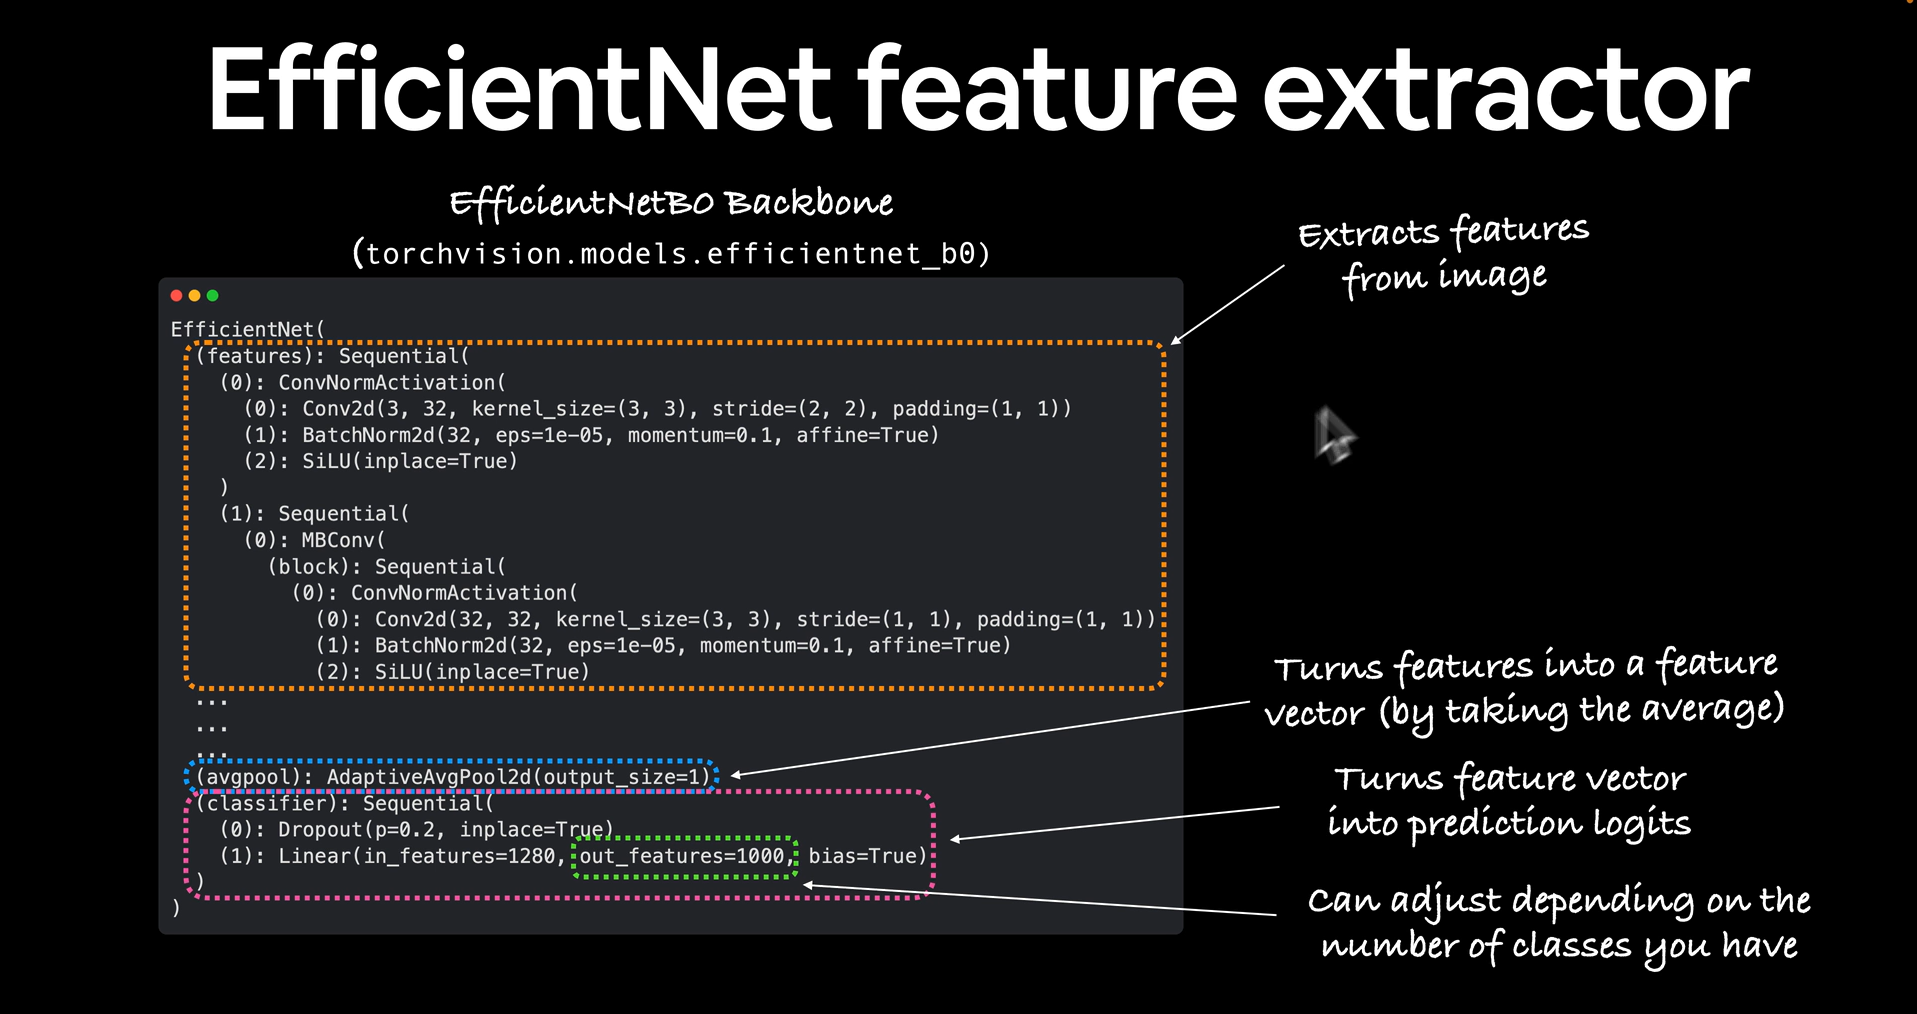

In [21]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT ## ".DEFAULT" -> best available weights
model = torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 162MB/s]


In [22]:
model # check out how many layers are here -> someone has handcrafted these layers

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [23]:
model.features ## extract patterns from the image -> using patterns learned on imagenet -> might be a big tensor

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [24]:
model.avgpool ## compress the feautures into a single vector of size 1280
## big tensor -> vector

AdaptiveAvgPool2d(output_size=1)

In [29]:
model.classifier  ## **classfier head that we'll modify for our problem**

"""
Here by deafault, there are 1000 output features since imagenet1k -> trained on 1000 classes
We need to make it to 3 -> pizza, steak, sushi
base layers stay frozen -> dont update during training
change the input data and output head
"""

'\nHere by deafault, there are 1000 output features since imagenet1k -> trained on 1000 classes\nWe need to make it to 3 -> pizza, steak, sushi \nbase layers stay frozen -> dont update during training\nchange the input data and output head\n'

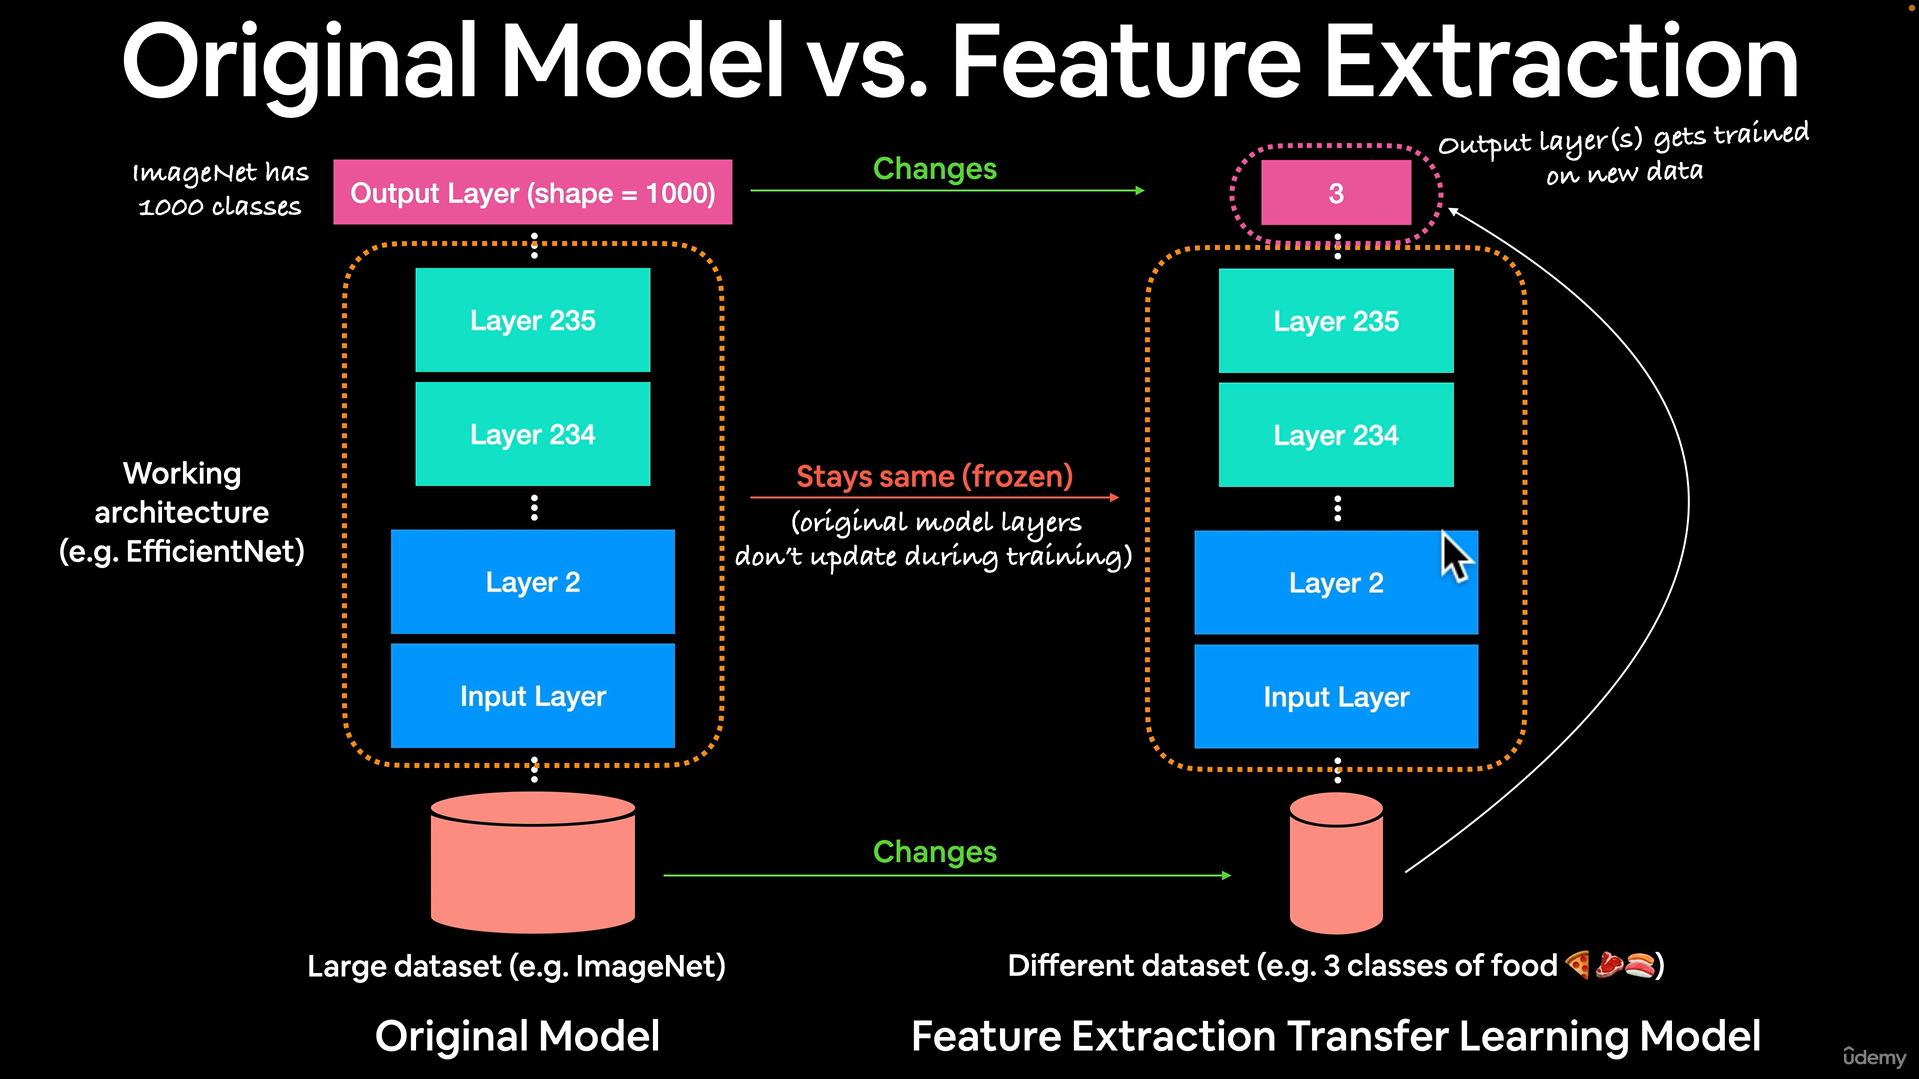



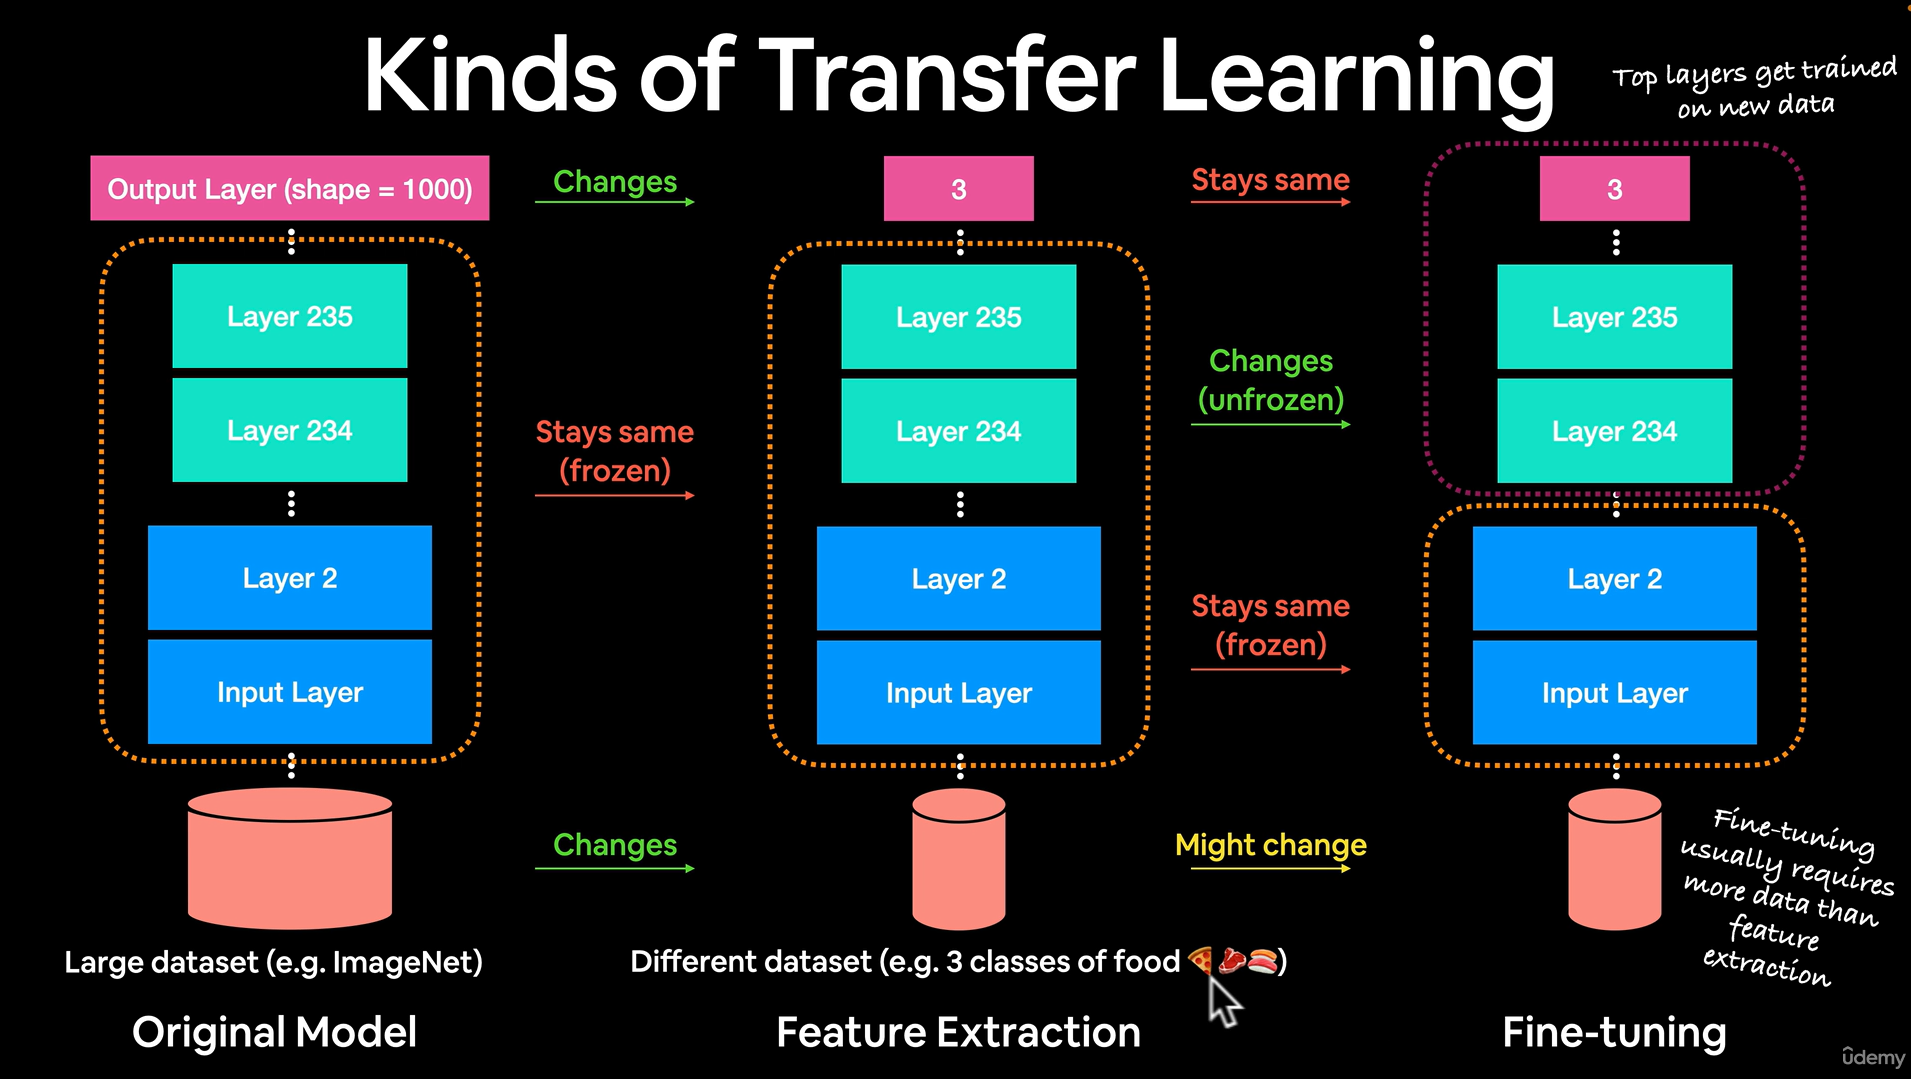



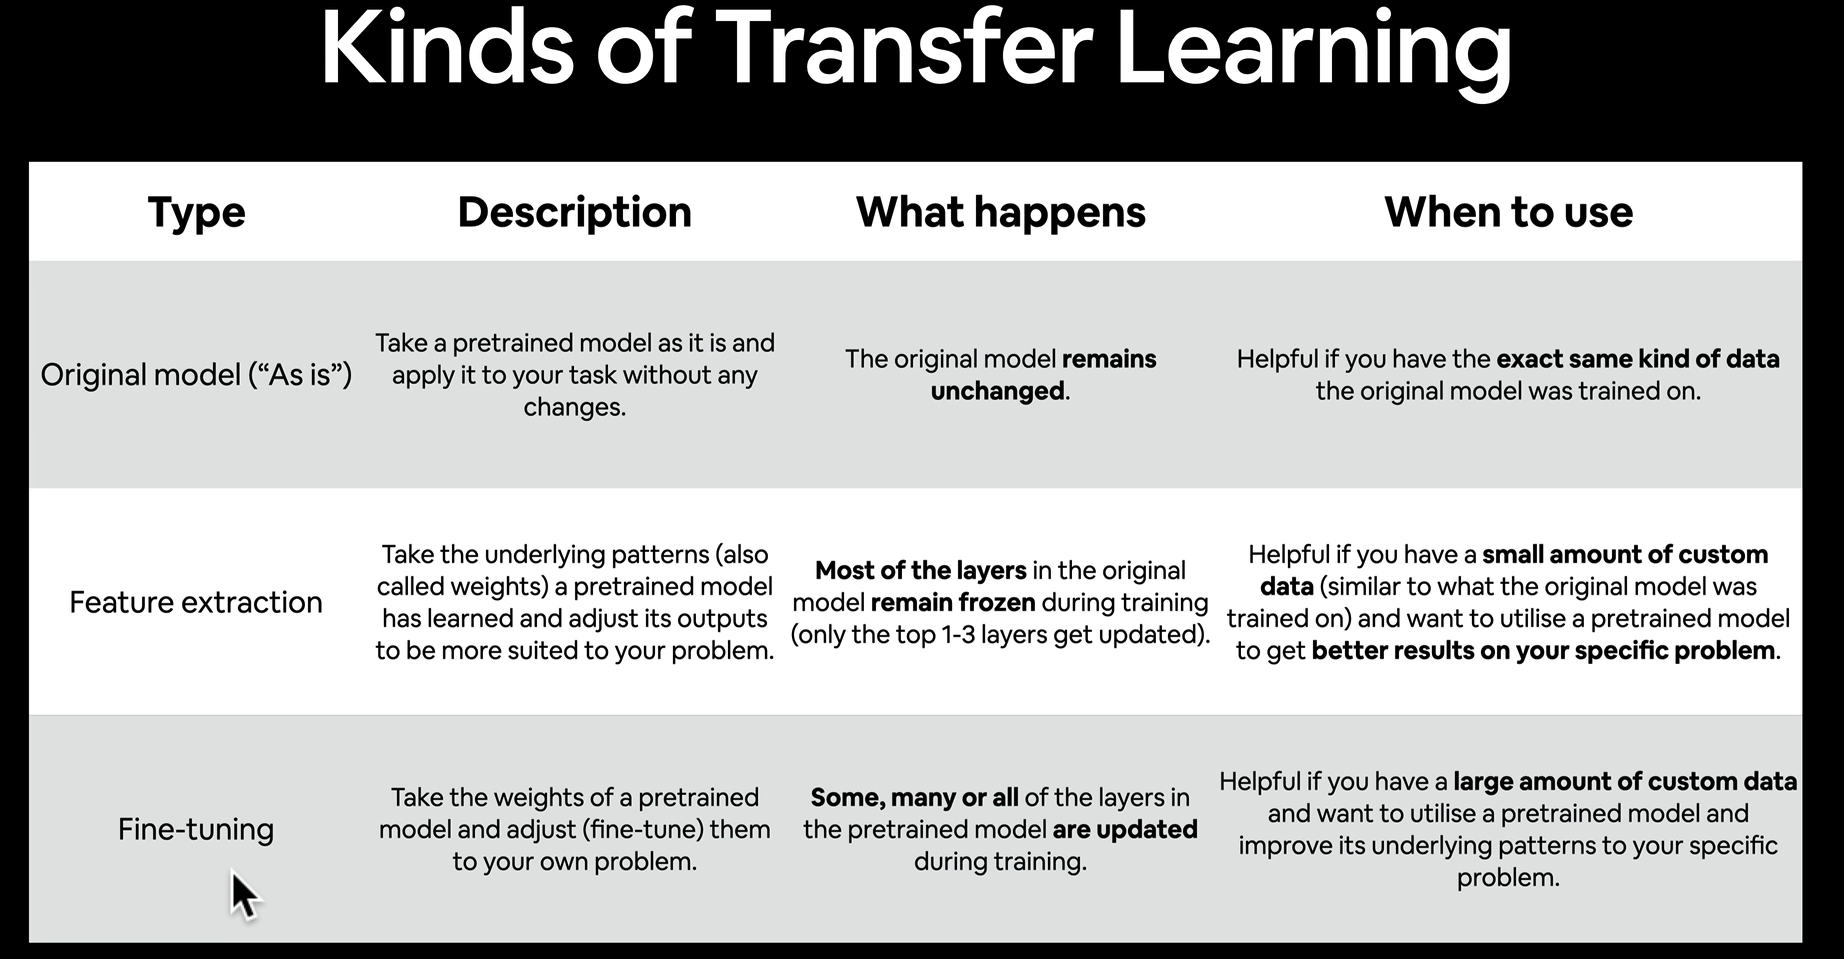
we can perform `fine tuning` when we have large amounts of data. Ex: 1000 images per class. our data has around 100 images.

Order stays same:
original model -> feature extraction -> fine tuning (layer by layer)

## 3.3. Getting a summary of our model with `torchinfo.summary()`

| Parameter | Type | Default | Short description | Supported values / notes |
|---|---:|---|---|---|
| model | `nn.Module` | — | PyTorch model to summarize | — |
| input_size | `Sequence` (tuple/list/torch.Size) | `None` | Shape of input including batch dim (used to generate fake input) | e.g. `(1,3,224,224)` |
| input_data | `Sequence[Tensors]` | `None` | Actual input tensors (pass args list or dict kwargs) | If provided, dtypes inferred |
| batch_dim | `int` | `None` | Which axis is batch dim (optimizes forward pass when set) | If `None`, batch dim assumed in `input_size` |
| cache_forward_pass | `bool` | `False` | Cache forward pass to avoid re-running expensive forward | Warning: cache may become stale if model/input change |
| col_names | `Iterable[str]` | `("output_size","num_params")` | Which columns to display in the summary | Supported: `"input_size"`, `"output_size"`, `"num_params"`, `"params_percent"`, `"kernel_size"`, `"groups"`, `"mult_adds"`, `"trainable"` |
| col_width | `int` | `25` | Column width (characters) | — |
| depth | `int` | `3` | How many nested layer levels to show | Lower hides deeper nested modules |
| device | `torch.device` | `None` | Device used for model & inputs during summary | If `None` inferred from inputs/params or `torch.cuda.is_available()` |
| dtypes | `List[torch.dtype]` | `None` | Data types for `input_size` (if not float) | Provide one per input when multiple inputs |
| mode | `str` | `"same"` | Whether to call `model.train()` / `model.eval()` during summary | `"train"`, `"eval"`, or `"same"` |
| row_settings | `Iterable[str]` | `("depth",)` | Extra row info to show for each layer | Supported: `"ascii_only"`, `"depth"`, `"var_names"` |
| verbose | `int` | `1` (0/1/2) | Output verbosity | `0`=quiet, `1`=print summary, `2`=show weights & bias layers |
| **kwargs | Any | — | Forward-pass kwargs passed to model.forward | Passing *args is no longer supported |
| Return | `ModelStatistics` | — | Object containing the full summary (stringable) | See `torchinfo/model_statistics.py` |


In [26]:
!pip install torchinfo

In [28]:
## print a summary
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224), # example of [bacth_size, colour_channels, height, width]
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In the above summary that all the layers are trainable. We'll need to freeze all these layers so that only the input and output are trainable.